In [34]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import _thread
import time

In [35]:
def random_matrix(shape):
    A = np.random.rand(shape[0], shape[1])*50
    return A

def random_integer_matrix(shape):
    return np.floor(random_matrix(shape))

138.430997671 60.8595704834 (112, 92)


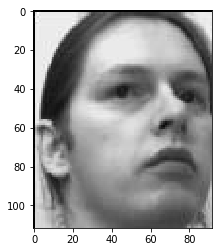

In [36]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

im = Image.open("image/umist_cropped.jpg")
data_orig = np.array(im)
# print(data_orig.shape)
# print(np.mean(data_orig), np.std(data_orig))

ws = (112,92)
data = data_orig[ws[0]:2*ws[0],ws[1]:ws[1]*2]
print(np.mean(data), np.std(data), data.shape)
plt.imshow(data, cmap='gray')
plt.show()

In [37]:
#Gibbs
X = data
I = 200
print(np.mean(X), np.std(X))

data_variance = (np.std(X)/I)**2
data_mean = np.mean(X)/I/2.5
#print(data_mean, data_variance)

gamma_scale = data_variance/data_mean # b/sqrt(a) == std
gamma_shape = data_mean/gamma_scale
print(gamma_scale, gamma_shape)

138.430997671 60.8595704834
0.334452487317 0.827806656672


In [38]:
import threading
import time

exitFlag = 0

def fnc(x_head, X, T, V, priors, k):
    p = T[ :, [k]].dot(V[ [k], :])/x_head
    S = np.random.binomial(X, p)

    alpha_T = priors["A_t"][:,k] + np.sum(S, axis = 1)
    alpha_V = priors["A_v"][k,:] + np.sum(S, axis = 0)


    beta_T = 1./(priors["B_t"][:,k] + np.sum(V[k,:]))
    beta_V = 1./(priors["B_v"][k,:] + np.sum(T[:,k]))

    T[:,k] = np.random.gamma(alpha_T, beta_T)
    V[k,:] = np.random.gamma(alpha_V, beta_V)

class myThread (threading.Thread):
    def __init__(self, x_head, X, T, V, priors, k):
        threading.Thread.__init__(self)
        self.x_head = x_head
        self.X = X
        self.T = T
        self.V = V
        self.priors = priors
        self.k = k
    def run(self,):
#         print ("Starting " + self.name)
        fnc(self.x_head, self.X, self.T, self.V, self.priors, self.k)
#         print ("Exiting " + self.name)

In [39]:
def sada(X, gamma_shape, gamma_scale, max_iter):
    W = X.shape[0]
    K = X.shape[1]
    I = 200
    A_t = np.ones((W,I))*gamma_shape
    B_t = np.ones((W,I))*gamma_scale
    A_v = np.ones((I,K))*gamma_shape
    B_v = np.ones((I,K))*gamma_scale
    priors = {}
    priors["A_t"] = A_t
    priors["B_t"] = B_t
    priors["A_v"] = A_v
    priors["B_v"] = B_v
    #alpha_T = np.zeros((W,I))
    
    T = np.random.gamma(A_t,B_t)
    V = np.random.gamma(A_v,B_v)
    
    last_time = 0

    for n in range(max_iter):

        x_head = T.dot(V)
        
        threads = []
        
        for k in range(I):
            t = myThread(x_head, X, T, V, priors, k)
            t.start()
            threads.append(t)

        for t in threads:
            t.join()
        
        if n % 50 == 0:
            mean_diff = np.mean(np.abs(X - np.dot(T,V)))
            now = time.time()
            diff_time = now-last_time
            print("diff - time: %s -- epoch %d: loss: "% (diff_time, n), mean_diff)
            last_time = now
    return T, V

T, V = sada(X, gamma_shape, gamma_scale, 200)

diff - time: 1515091479.7072299 -- epoch 0: loss:  1092.40608763
diff - time: 12.126223087310791 -- epoch 50: loss:  637.214485083
diff - time: 12.529552936553955 -- epoch 100: loss:  427.601680778
diff - time: 11.62624216079712 -- epoch 150: loss:  302.171940115


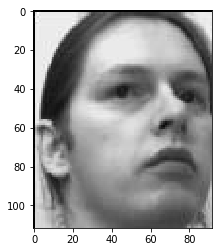

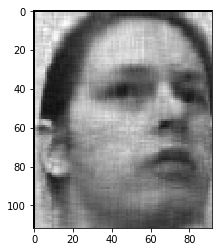

138.430997671 60.8595704834
138.76219225 60.2006719965


In [9]:
plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(np.dot(T,V), cmap='gray')
plt.show()

print(np.mean(X), np.std(X))
print(np.mean(np.dot(T,V)), np.std(np.dot(T,V)))

In [33]:
def sada_mask(X, mask, gamma_shape, gamma_scale, max_iter):
    
    X = X*mask
    
    W = X.shape[0]
    K = X.shape[1]
    I = 20
    A_t = np.ones((W,I))*gamma_shape
    B_t = np.ones((W,I))*gamma_scale
    A_v = np.ones((I,K))*gamma_shape
    B_v = np.ones((I,K))*gamma_scale
    
    T = np.random.gamma(A_t,B_t)
    V = np.random.gamma(A_v,B_v)

    
    for n in range(max_iter):

        x_head = T.dot(V)
        for k in range(I):
            p = T[ :, [k]].dot(V[ [k], :])/x_head
            S = np.random.binomial(X, p)
            
            alpha_T = A_t[:,k] + np.sum(S, axis = 1)
            alpha_V = A_v[k,:] + np.sum(S, axis = 0)
            
            beta_T = 1./(B_t[:,k] + (np.einsum("ij,j->i",mask, V[k,:])))
            beta_V = 1./(B_v[k,:] + (np.einsum("ij,i->j",mask, T[:,k])))
            
            T[:,k] = np.random.gamma(alpha_T, beta_T)
            V[k,:] = np.random.gamma(alpha_V, beta_V)
            
        if n % 50 == 0:
            mean_diff = np.mean(np.abs(X - np.dot(T,V)))
            print("epoch %d: loss: "%n, mean_diff)
    return T, V

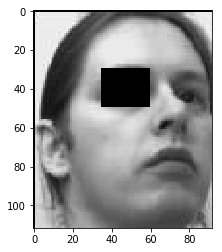

In [36]:
mask = np.ones((112,92)).astype(np.uint8)
mask[30:50,35:60] = 0
plt.imshow(X*mask, cmap='gray')
plt.show()

In [40]:
T_, V_ = sada_mask(X, mask, gamma_shape, gamma_scale, 1000)

epoch 0: loss:  48.7421113595
epoch 50: loss:  21.1177642367
epoch 100: loss:  16.2870394851
epoch 150: loss:  14.7839621876
epoch 200: loss:  14.239854711
epoch 250: loss:  13.5496379523
epoch 300: loss:  13.2153869985
epoch 350: loss:  13.7029684752
epoch 400: loss:  13.6017568469
epoch 450: loss:  13.0416774745
epoch 500: loss:  12.9795327995
epoch 550: loss:  12.7672017957
epoch 600: loss:  12.6692679501
epoch 650: loss:  12.6801600224
epoch 700: loss:  12.7478200195
epoch 750: loss:  13.3674203663
epoch 800: loss:  12.5695385569
epoch 850: loss:  12.4195289434
epoch 900: loss:  13.0735016284
epoch 950: loss:  12.5297603665


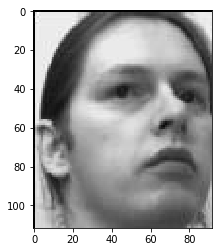

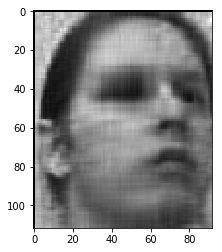

In [41]:
plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(np.dot(T_,V_), cmap='gray')
plt.show()